In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import OrderedDict

np.random.seed(1234)

In [2]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA")
else:
    device = torch.device("cpu")
    print("CPU")

CUDA


In [3]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

In [14]:
class PINN():
    def __init__(self, X, layers, lb, rb, q_c):
        
        self.x = torch.tensor(X, requires_grad=True).float().to(device)
        self.q_c = torch.tensor(q_c).float().to(device)

        self.lb = lb
        self.rb = rb

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lfbgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=0.1,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=0.01)
        self.iter = 0

    def model_value(self, x):
        u = self.dnn(x)
        return u
    
    def boundary_condition(self, cond, u, u_x, u_2x, u_3x):
        bc_loss = 0

        match cond:
            case 'pinned':
                bc_loss += u**2 + u_2x**2
            case 'fixed':
                bc_loss += u**2 + u_x**2
            case 'free':
                bc_loss += u_2x**2 + u_3x**2
            case 'roller':
                bc_loss += u_x**2 + u_3x**2

        return bc_loss
    
    def loss_func(self, x):
        u = self.model_value(x)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_2x = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        u_3x = torch.autograd.grad(u_2x, x, torch.ones_like(u_2x), create_graph=True)[0]
        u_4x = torch.autograd.grad(u_3x, x, torch.ones_like(u_3x), create_graph=True)[0]

        # BC
        bc_loss = self.boundary_condition(self.lb, u[0], u_x[0], u_2x[0], u_3x[0])
        bc_loss += self.boundary_condition(self.rb, u[-1], u_x[-1], u_2x[-1], u_3x[-1])

        # PDE
        residual = torch.mean((u_4x - self.q_c)**2)
        return residual + bc_loss


    def lbfgs_func(self):
        loss = self.loss_func(self.x)

        self.optimizer_lfbgs.zero_grad()
        loss.backward()

        self.iter += 1
        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {loss.item():.9f}")
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            loss = self.loss_func(self.x)

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()

            if epoch % 200 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.9f}")

        self.optimizer_lfbgs.step(self.lbfgs_func)

    def predict(self, X, q_c, L, E, I):
        x = torch.tensor(X, requires_grad=True).float().to(device)

        self.dnn.eval()
        u_c = self.model_value(x)
        u_c = u_c.detach().cpu().numpy()
        u = (q_c * L**4 / (E*I)) * u_c
        return u

In [21]:
# Parameters

E = 50000.0
I = 1
L = 2.0

def Q(x):
    q = np.ones(len(x)) * -1e5
    return q

In [25]:
def exact_solution(x):
    w = Q(x)*x**2/(48*E*I)*(3*L**2 - 5*L*x + 2*x**2)
    return w

In [ ]:
x = np.random.uniform(0, L, 100)
x_t = x / L
x_t = np.append(x_t, [0, 1])
x_t = np.sort(x_t).reshape(-1, 1)

q_c = np.max(Q(x))
q = Q(x) / q_c

layers = [1, 20, 20, 20, 1]
lb = 'fixed'
rb = 'pinned'

model = PINN(x_t, layers, lb, rb, q)
model.train(1000)


Epoch 0, Loss: 1.512180567
Epoch 200, Loss: 0.000384073
Epoch 400, Loss: 0.000004134
Epoch 600, Loss: 0.000001825
Epoch 800, Loss: 0.000001593
Iter: 100, Loss: 0.000000724
Iter: 200, Loss: 0.000000008


L2 Error: 7.23186903558728


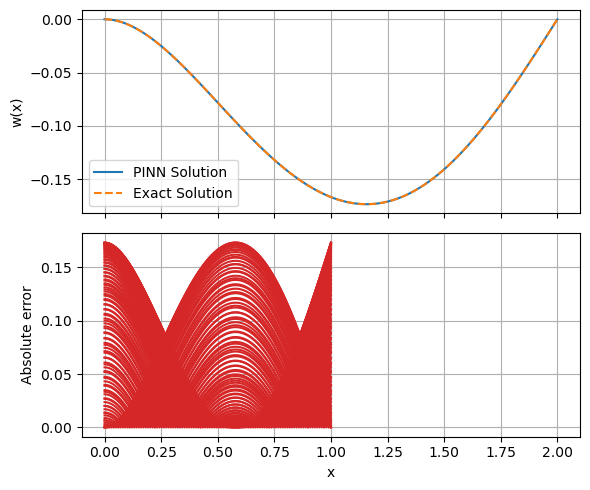

In [30]:
x = np.linspace(0, 1, 100).reshape(-1, 1)
x1 = np.linspace(0, L, 100).reshape(-1, 1)
u_pred = model.predict(x, q_c, L, E, I)
u_exact = exact_solution(x1.flatten())

u_error = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact,2)
abs_error = np.abs(u_pred - u_exact)
print(f"L2 Error: {u_error}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

ax1.plot(x1, u_pred, label="PINN Solution")
ax1.plot(x1, u_exact, label="Exact Solution", linestyle="dashed")
ax1.set(ylabel='w(x)')
ax1.legend()
ax1.grid()

ax2.plot(x, abs_error, 'tab:red')
ax2.set(xlabel='x', ylabel='Absolute error')
ax2.grid()

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Defines when to switch to scientific notation

ax2.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

L2 Error: 0.0001460622267574389


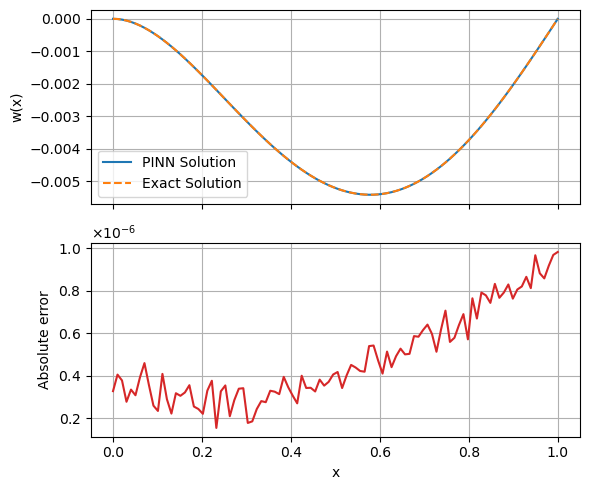

In [23]:
x = np.linspace(0,L,100).reshape(-1, 1)

# Predict
u_pred = model.predict(x)

# Exact
u_exact = exact_solution(x)

u_error = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact,2)
abs_error = np.abs(u_pred - u_exact)
print(f"L2 Error: {u_error}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

ax1.plot(x, u_pred, label="PINN Solution")
ax1.plot(x, u_exact, label="Exact Solution", linestyle="dashed")
ax1.set(ylabel='w(x)')
ax1.legend()
ax1.grid()

ax2.plot(x, abs_error, 'tab:red')
ax2.set(xlabel='x', ylabel='Absolute error')
ax2.grid()

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Defines when to switch to scientific notation

ax2.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()